In [1]:
import os

import numpy as np
from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [16]:
import matplotlib.pyplot as plt

In [2]:
def prepare_sequences(x_train, window_length, random_indices):
    full_sequence = x_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_sequence) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_sequence[window_range])
        contain_outlier = len(set(window_range).intersection(set(random_indices))) > 0
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), outliers


def get_signal(size, outliers_size=0.01):
    sig = np.expand_dims(np.random.normal(loc=0, scale=1, size=(size, 1)), axis=1)
    if outliers_size < 1:  # percentage.
        outliers_size = int(size * outliers_size)
    random_indices = np.random.choice(range(size), size=outliers_size, replace=False)
    sig[random_indices] = np.random.randint(6, 9, 1)[0]
    return sig, random_indices


def tp_fn_fp_tn(total, expected, actual):
    tp = len(set(expected).intersection(set(actual)))
    fn = len(set(expected) - set(actual))
    fp = len(set(actual) - set(expected))
    tn = len((total - set(expected)).intersection(total - set(actual)))
    return tp, fn, fp, tn

In [9]:
window_length = 10
select_only_last_state = False
model_file = 'model.h5'
hidden_dim = 16

In [3]:
np.random.seed(123)

In [12]:
signal_train, _ = get_signal(100000, outliers_size=0)
signal_train.shape

In [14]:
x_train, _ = prepare_sequences(signal_train, window_length, [])
x_train.shape

(99991, 10, 1)

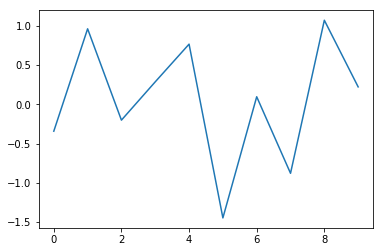

In [37]:
plt.plot(x_train[800])
plt.show()

In [10]:
# 1 percent are outliers.
signal_test, random_indices = get_signal(100000, outliers_size=0.01)
x_test, contain_outliers = prepare_sequences(signal_test, window_length, random_indices)
outlier_indices = np.where(contain_outliers)[0]

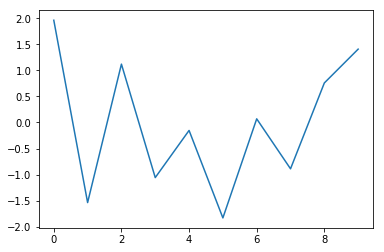

In [36]:
plt.plot(x_test[800])
plt.show()

In [48]:
# if os.path.isfile(model_file):
#         m = load_model(model_file)
#     else:
m = Sequential()
if select_only_last_state:
    m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
    m.add(RepeatVector(window_length))
else:
    m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))

m.add(Dropout(rate=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))

m.compile(loss='mse', optimizer='adam')
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 16)            1152      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = m.fit(x_train, x_train, batch_size=64, epochs=5, validation_data=(x_test, x_test)).history
m.save(model_file)

Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 37s 373us/step - loss: 0.1223 - val_loss: 0.2829
Epoch 2/5
99991/99991 [==============================] - 35s 347us/step - loss: 0.0158 - val_loss: 0.2493
Epoch 3/5
99991/99991 [==============================] - 35s 351us/step - loss: 0.0125 - val_loss: 0.2155
Epoch 4/5
99991/99991 [==============================] - 35s 351us/step - loss: 0.0111 - val_loss: 0.1845
Epoch 5/5
99991/99991 [==============================] - 35s 355us/step - loss: 0.0103 - val_loss: 0.1491


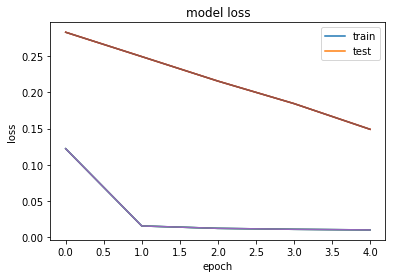

In [52]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [53]:
pred_x_test = m.predict(x_test)

In [54]:
pred_x_test.shape

(99991, 10, 1)

In [55]:
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 1.0, accuracy = 1.0
